## Solving:

## Graphene

## Import libraries

In [1]:
import kwant
import numpy as np
import scipy.sparse.linalg as lin

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import os.path
def save_image(name):
    folder = "./figures/"
    if os.path.exists(folder + name + ".png"):
        raise Exception("File already exist")
        return 0
    
    plt.savefig(folder + name + ".png", dpi=300)

## Create an “empty” tight binding system

In [2]:
# defining honeycomb lattice in a general way
sin_30, cos_30 = (1 / 2, np.sqrt(3) / 2)
graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
                                 [(0, 0), (0, 1 / np.sqrt(3))])

a, b = graphene.sublattices
r = 10
w = 2
pot = 0.1

syst = kwant.Builder()

## Set its matrix elements and hoppings

In [3]:
# shape of scattering region
def circle(pos):
    x, y = pos
    return x ** 2 + y ** 2 < r ** 2

# p-n junction between the two kinds of atoms
def potential(site):
    (x, y) = site.pos
    d = y * cos_30 + x * sin_30
    return pot * np.tanh(d / w)

syst[graphene.shape(circle, (0, 0))] = potential

In [4]:
# specify the hoppings
hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

# fun ways to modify the scattering region
#del syst[a(0, 0)]
#syst[a(-2, 1), b(2, 2)] = -1

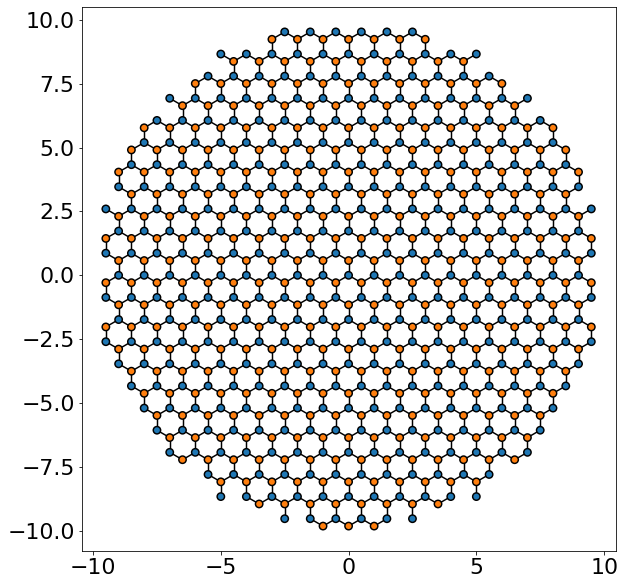

In [5]:
_ = kwant.plot(syst, site_lw=0.1, colorbar=False, fig_size=(10,10))

In [6]:
# To highlight the two sublattices of graphene, we plot one with
# a filled, and the other one with an open circle:
#def family_colors(site):
#    return 0 if site.family == a else 1

# Plot the closed system without leads.
#_ = kwant.plot(syst, site_color=family_colors, site_lw=0.1, colorbar=False, fig_size=(20,10))

## Compute some eigenvalues of the closed system

In [7]:
# Compute some eigenvalues of the closed system
#sparse_mat = syst.finalized().hamiltonian_submatrix(sparse=True)

#evs = lin.eigs(sparse_mat, 2)[0]
#print(evs.real)

##  Make leads

In [8]:
# left lead
# specifying symmetry 
sym = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))

# specifying lead shape
def lead_shape(pos):
    x, y = pos
    return (-0.4 * r < y < 0.4 * r)

lead = kwant.Builder(sym)
lead[graphene.shape(lead_shape, (0, 0))] = -pot
lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

# the second lead, going to the top right
sym2 = kwant.TranslationalSymmetry(graphene.vec((0, 1)))

def lead2_shape(pos):
    v = pos[1] * sin_30 - pos[0] * cos_30
    return (-0.4 * r < v < 0.4 * r)

lead2 = kwant.Builder(sym2)
lead2[graphene.shape(lead2_shape, (0, 0))] = pot
lead2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1

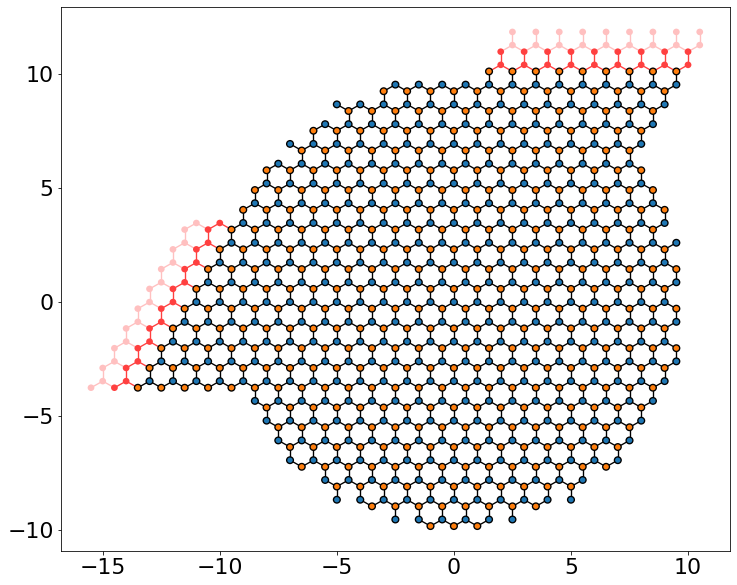

In [9]:
# attaching leads
syst.attach_lead(lead)
syst.attach_lead(lead2)

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = kwant.plot(syst, site_lw=0.1, lead_site_lw=0, colorbar=False, ax=ax)
save_image("graphene")

In [10]:
# finalize system
syst = syst.finalized()

## Pass the finalized system to a solver.

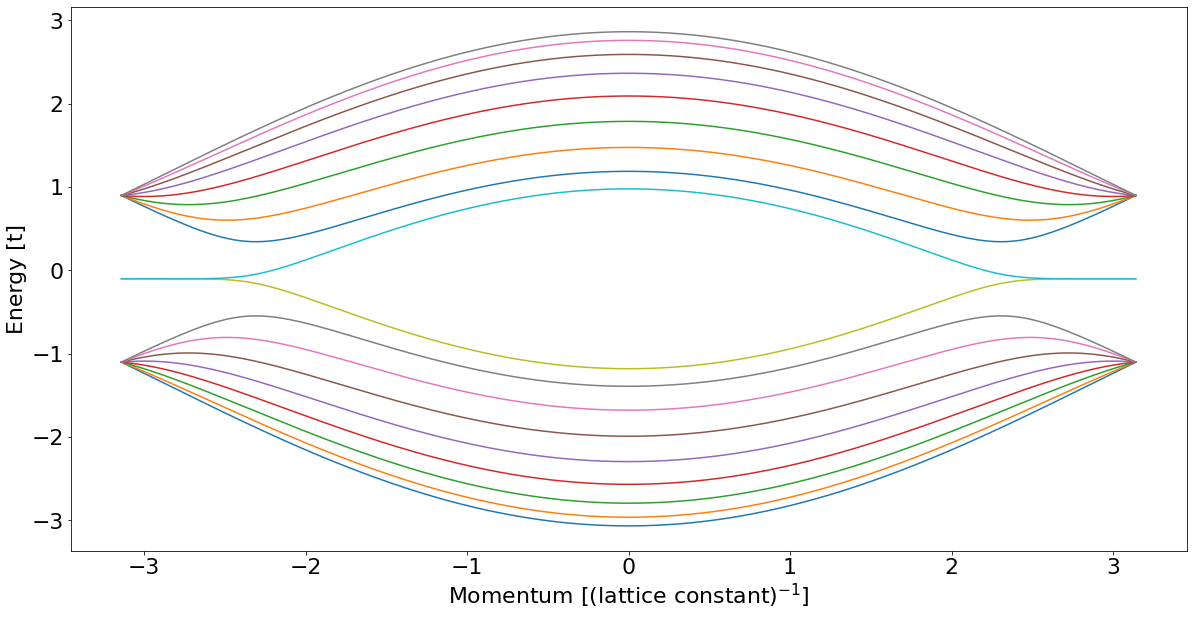

In [11]:
# Compute the band structure of lead 1
momenta = np.linspace(-np.pi, np.pi, 500)

bands = kwant.physics.Bands(syst.leads[0])
energies = [bands(k) for k in momenta]

plt.figure(figsize=(20,10))
plt.plot(momenta, energies)
plt.xlabel(r'Momentum [(lattice constant)$^{-1}$]')
plt.ylabel("Energy [t]")
save_image("graphene_band_structure")

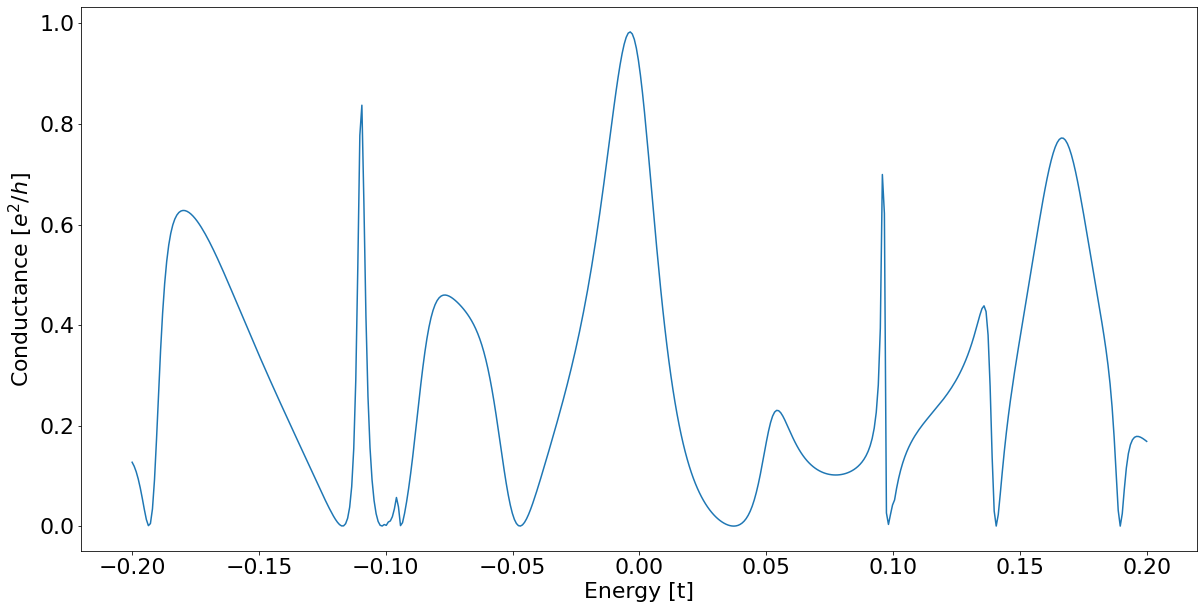

In [12]:
# Plot conductance.
energies = np.linspace(-2 * pot, 2 * pot, 500)

# Compute transmission as a function of energy
data = []
for energy in energies:
    smatrix = kwant.smatrix(syst, energy)
    data.append(smatrix.transmission(0, 1))

plt.figure(figsize=(20,10))
plt.plot(energies, data)
plt.xlabel("Energy [t]")
plt.ylabel(r'Conductance $[e^2/h]$')
save_image("graphene_conductance")